In [1]:
import sys
sys.path.append('/home/mhasan3/Desktop/WorkFolder/')

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [3]:
# import the necessary keras packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet, MiniGoogleNet
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from imutils import paths

In [4]:
args = {
    "output": f"/home/mhasan3/Desktop/WorkFolder/keras_dir/biblio2/chap6_ensembling/outputs/",
    "models": f"/home/mhasan3/Desktop/WorkFolder/keras_dir/biblio2/chap6_ensembling/models/",
    "num_models": 5
}

In [5]:
(trainx, trainy), (testx, testy) = cifar10.load_data()
trainx = trainx.astype("float") / 255.0
testx = testx.astype("float") / 255.0

# encode the labels
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)
unique_class_names = ['airplanes', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
# construct the data augmentation
aug = ImageDataGenerator(rotation_range=10,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         horizontal_flip=True,
                         fill_mode='nearest')

[INFO] training model 1/5.....
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
782/782 [==============================] - 80s 103ms/step - loss: 1.4174 - acc: 0.4912 - val_loss: 1.2141 - val_acc: 0.5705
Epoch 2/40
782/782 [==============================] - 74s 95ms/step - loss: 1.0231 - acc: 0.6375 - val_loss: 0.9188 - val_acc: 0.6738
Epoch 3/40
782/782 [==============================] - 74s 95ms/step - loss: 0.8866 - acc: 0.6865 - val_loss: 0.9493 - val_acc: 0.6782
Epoch 4/40
782/782 [==============================] - 75s 95ms/step - loss: 0.8052 - acc: 0.7182 - val_loss: 0.8881 - val_acc: 0.6866
Epoch 5/40
782/782 [==============================] - 74s 95ms/step - loss: 0.7482 - acc: 0.7370 - val_loss: 0.8237 - val_acc: 0.7138
Epoch 6/40
782/782 [==============================] - 74s 95ms/

782/782 [==============================] - 74s 95ms/step - loss: 0.3440 - acc: 0.8808 - val_loss: 0.5626 - val_acc: 0.8226
Epoch 34/40
782/782 [==============================] - 75s 95ms/step - loss: 0.3337 - acc: 0.8853 - val_loss: 0.5100 - val_acc: 0.8372
Epoch 35/40
782/782 [==============================] - 75s 96ms/step - loss: 0.3318 - acc: 0.8843 - val_loss: 0.4236 - val_acc: 0.8582
Epoch 36/40
782/782 [==============================] - 75s 96ms/step - loss: 0.3286 - acc: 0.8856 - val_loss: 0.5034 - val_acc: 0.8372
Epoch 37/40
782/782 [==============================] - 75s 95ms/step - loss: 0.3211 - acc: 0.8898 - val_loss: 0.4808 - val_acc: 0.8372
Epoch 38/40
782/782 [==============================] - 74s 95ms/step - loss: 0.3172 - acc: 0.8879 - val_loss: 0.4511 - val_acc: 0.8534
Epoch 39/40
782/782 [==============================] - 75s 95ms/step - loss: 0.3173 - acc: 0.8889 - val_loss: 0.6703 - val_acc: 0.8015
Epoch 40/40
782/782 [==============================] - 75s 96ms/ste

ValueError: Format 'txt' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

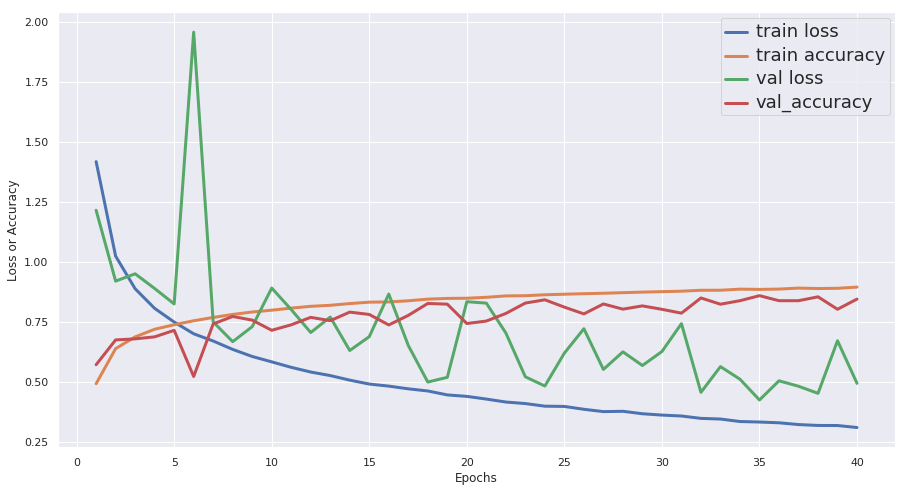

In [7]:
total_epochs = 40
lr = 0.01

# loop over the no of models to train
for i in range(args["num_models"]):
    print(f'[INFO] training model {i+1}/{args["num_models"]}.....')
    opt = SGD(lr=lr, momentum=0.9, nesterov=True, decay=lr/total_epochs)
    model = MiniGoogleNet.build(width=32, height=32, depth=3, classes=len(unique_class_names))
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])
    # train the model
    H = model.fit_generator(aug.flow(trainx, trainy, batch_size=64),
                            validation_data=(testx, testy),
                            epochs=total_epochs, verbose=1)
    #save the model
    p = [args["models"], f"model_{i}.hdf5"]
    model.save(os.path.sep.join(p))

    # evaluate the network
    print ( "[INFO] evaluating network..." )
    predictions = model.predict(testx, batch_size=64)
    report = classification_report(testy.argmax(axis=1 ),
    predictions.argmax(axis=1 ), target_names=unique_class_names)

    # save the classification rreport and plot
    p = [args["output"], f"model_{i}.txt"]
    f = open(os.path.sep.join(p), "w")
    f.write(report)
    f.close()


    # plot the performance
    epochs = range(1,total_epochs+1)
    loss = H.history['loss']
    accuracy = H.history['acc']
    val_loss = H.history['val_loss']
    val_accuracy = H.history['val_acc']
    plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                           columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

    # do the actual plots
    sns.set(font_scale=1)
    f, ax = plt.subplots(1, 1, figsize=(15,8))
    sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
    sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
    sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
    sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
    ax.set_ylabel('Loss or Accuracy')
    ax.set_xlabel('Epochs')
    plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
    p = [args["output"], f"model_{i}.png"]      
    plt.savefig(os.path.sep.join(p))
    plt.close()

    print("=" * 50)